In [4]:
import itertools
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import datetime

weight_para_space = [0,1]
weight_paras = np.array(list(itertools.product(weight_para_space, repeat=20)))
comb_paras = weight_paras[1:]

def get_time():
    nowTime=datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    return nowTime


def get_data_from_file(file):
    data =  pd.read_excel(file)
    data_list = []
    date_array = data.iloc[:,0].unique()
    for date in date_array:
        ser = data.loc[data.iloc[:,0]==date,'s_entry'].values
        data_list.append(ser)
    data_array = np.array(data_list)
    return date_array, data_array

def get_info_from_comb(comb_index, base_info, date_array):
    
    index_info = (comb_index+1).tolist()
    date_info = [i.replace('-','') for i in date_array[comb_index]]
    week_info = base_info.loc[base_info['日期'].isin(date_info),'星期'].values.tolist()
    
    return index_info, date_info, week_info

def compute_comb_avg(data_array, comb_index):
    #序列组合
    ser_comb = data_array[comb_index]
    
    #序列组合的平均值
    ser_comb_avg = np.mean(ser_comb,axis=0).astype(int)
    #序列组合的滑动平均值
    ser_comb_iter_avg = ser_comb[0]
    for i in ser_comb:
        ser_comb_iter_avg = (ser_comb_iter_avg+i)/2
    ser_comb_iter_avg = ser_comb_iter_avg.astype(int)
    
    return ser_comb_avg, ser_comb_iter_avg



def manager(his_file, iter_file, out_file,stat_type = 'mae'):
    
    #stat_type: corr,euc_dis,mae
    
    if stat_type=='corr':
        def dis_compute(x1,x2,y):           
            dis_avg = "%0.6f"%pearsonr(x1,y)[0]
            dis_m_avg =  "%0.6f"%pearsonr(x2,y)[0]
            return dis_avg,dis_m_avg
    
    elif stat_type=='euc_dis':
        def dis_compute(x1,x2,y):           
            dis_avg = np.sqrt(np.square(np.abs(x1-y))).astype(int)
            dis_m_avg =  np.sqrt(np.square(np.abs(x2-y))).astype(int)
            return dis_avg,dis_m_avg
    elif stat_type=='mae':
        def dis_compute(x1,x2,y):           
            dis_avg = np.mean(np.abs(x1-y)).astype(int)
            dis_m_avg =  np.mean(np.abs(x2-y)).astype(int)
            return dis_avg,dis_m_avg
    
    print(get_time(),"starting compute %s"%his_file)
    his_date_array, his_data_array = get_data_from_file(his_file)
    iter_date_array, iter_data_array = get_data_from_file(iter_file)
    iter_date_list = [i.replace('-','') for i in iter_date_array]
    iter_week_array = base_info.loc[base_info['日期'].isin(iter_date_list),'星期'].values

    result_list = []
    f = open(out_file,'a+') 
    for n,(iter_week, iter_date, iter_data) in enumerate(zip(iter_week_array,iter_date_list,iter_data_array)):

        for comb_para in comb_paras:
            comb_index = np.where(comb_para==1)[0]
            c_index_info, c_date_info, c_week_info  = get_info_from_comb(comb_index, base_info, his_date_array)
            ser_comb_avg, ser_comb_move_avg = compute_comb_avg(his_data_array, comb_index)
            if  len(iter_data)==0:
                dis_avg = np.abs(ser_comb_avg-iter_data).astype(int)
                dis_m_avg = np.abs(ser_comb_move_avg-iter_data).astype(int)
            else:
                dis_avg,dis_m_avg = dis_compute(ser_comb_avg,ser_comb_move_avg,iter_data)

       
            """
            #写入hive
            data_cur.execute("insert into hislike_comb_result_0030 partition(task_id=1) values('%s','%s','%s','%s','%s','%s','%s','%s','%s',%s,%s)"\
                             %(iter_date,str(c_date_info).replace("'",''),iter_week,str(c_week_info).replace("'",''),n+1,c_index_info,\
                                        iter_data.tolist(),ser_comb_avg.tolist(),ser_comb_move_avg.tolist(),dis_avg,dis_m_avg))
            """

            row_str  = "%s|%s|%s|%s|%s|%s|%s|%s|%s|%s|%s"%\
                             (iter_date,str(c_date_info).replace("'",''),iter_week,str(c_week_info).replace("'",''),n+1,c_index_info,iter_data.tolist(),ser_comb_avg.tolist(),ser_comb_move_avg.tolist(),dis_avg,dis_m_avg)
            
            f.writelines(row_str+'\n')

            #result_list.append([iter_date,c_date_info,iter_week,c_week_info,n+1,c_index_info,iter_data,ser_comb_avg,ser_comb_move_avg,dis_avg,dis_m_avg])
    f.close()
    #result_pd =  pd.DataFrame(result_list,columns=['日期','对照日期','星期','对照星期','序号','对照序号','原序列','对比均值','对比滑动平均','均值法距离','滑动平均距离'])
    
    print(get_time(),"complete compute %s"%his_file)

In [ ]:
base_info_file ="2019_base_info.xlsx"
base_info = pd.read_excel(base_info_file, index_col=0)


result_pd = manager("data/query_result_参照集一_半小时_1104_1129.xlsx" , "data/query_result_遍历集一_半小时_1202_1206.xlsx", "output_mae/test_0030_1.txt")
result_pd = manager("data/query_result_参照集二_半小时_1111_1206.xlsx" , "data/query_result_遍历集二_半小时_1209_1213.xlsx", "output_mae/test_0030_2.txt")
result_pd = manager("data/query_result_参照集一_小时_1104_1129.xlsx" , "data/query_result_遍历集一_小时_1202_1206.xlsx", "output_mae/test_0060_1.txt")
result_pd = manager("data/query_result_参照集二_小时_1111_1206.xlsx" , "data/query_result_遍历集二_小时_1209_1213.xlsx", "output_mae/test_0060_2.txt")
#result_pd = manager("data/query_result_参照集一_日_1104_1129.xlsx" , "data/query_result_遍历集一_日_1202_1206.xlsx", "output/test_2400_1.txt")
#result_pd = manager("data/query_result_参照集二_日_1111_1206.xlsx" , "data/query_result_遍历集二_日_1209_1213.xlsx", "output/test_2400_2.txt")

2020-06-05 10:51:10 starting compute data/query_result_参照集一_半小时_1104_1129.xlsx
2020-06-05 13:51:37 complete compute data/query_result_参照集一_半小时_1104_1129.xlsx
2020-06-05 13:51:37 starting compute data/query_result_参照集二_半小时_1111_1206.xlsx
2020-06-05 16:51:45 complete compute data/query_result_参照集二_半小时_1111_1206.xlsx
2020-06-05 16:51:45 starting compute data/query_result_参照集一_小时_1104_1129.xlsx
2020-06-05 19:14:10 complete compute data/query_result_参照集一_小时_1104_1129.xlsx
2020-06-05 19:14:10 starting compute data/query_result_参照集二_小时_1111_1206.xlsx


In [9]:
result_pd = manager("data/query_result_参照集一_日_1104_1129.xlsx" , "data/query_result_遍历集一_日_1202_1206.xlsx", "output_corr/test_2400_1.txt")
result_pd = manager("data/query_result_参照集二_日_1111_1206.xlsx" , "data/query_result_遍历集二_日_1209_1213.xlsx", "output_corr/test_2400_2.txt")

2020-06-03 15:56:24 starting compute data/query_result_参照集一_日_1104_1129.xlsx
2020-06-03 18:02:02 complete compute data/query_result_参照集一_日_1104_1129.xlsx
2020-06-03 18:02:02 starting compute data/query_result_参照集二_日_1111_1206.xlsx
2020-06-03 20:07:04 complete compute data/query_result_参照集二_日_1111_1206.xlsx


In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [27]:
os.chdir('/root/test/data1')

In [45]:
dirs = os.listdir()

In [46]:
dirs

['欧式距离日粒度(算术平均)',
 '平均绝对误差30分钟粒度(滑动平均)',
 '相关系数60分钟粒度(滑动平均)',
 '平均绝对误差30分钟粒度(算术平均)',
 '欧式距离日粒度(滑动平均)',
 '平均绝对误差60分钟粒度(滑动平均)',
 '相关系数60分钟粒度(算术平均)',
 '相关系数30分钟粒度(算术平均)',
 '平均绝对误差60分钟粒度(算术平均)',
 '相关系数30分钟粒度(滑动平均)']

欧式距离日粒度(算术平均)
平均绝对误差30分钟粒度(滑动平均)
相关系数60分钟粒度(滑动平均)
平均绝对误差30分钟粒度(算术平均)
欧式距离日粒度(滑动平均)
平均绝对误差60分钟粒度(滑动平均)
相关系数60分钟粒度(算术平均)
相关系数30分钟粒度(算术平均)
平均绝对误差60分钟粒度(算术平均)
相关系数30分钟粒度(滑动平均)


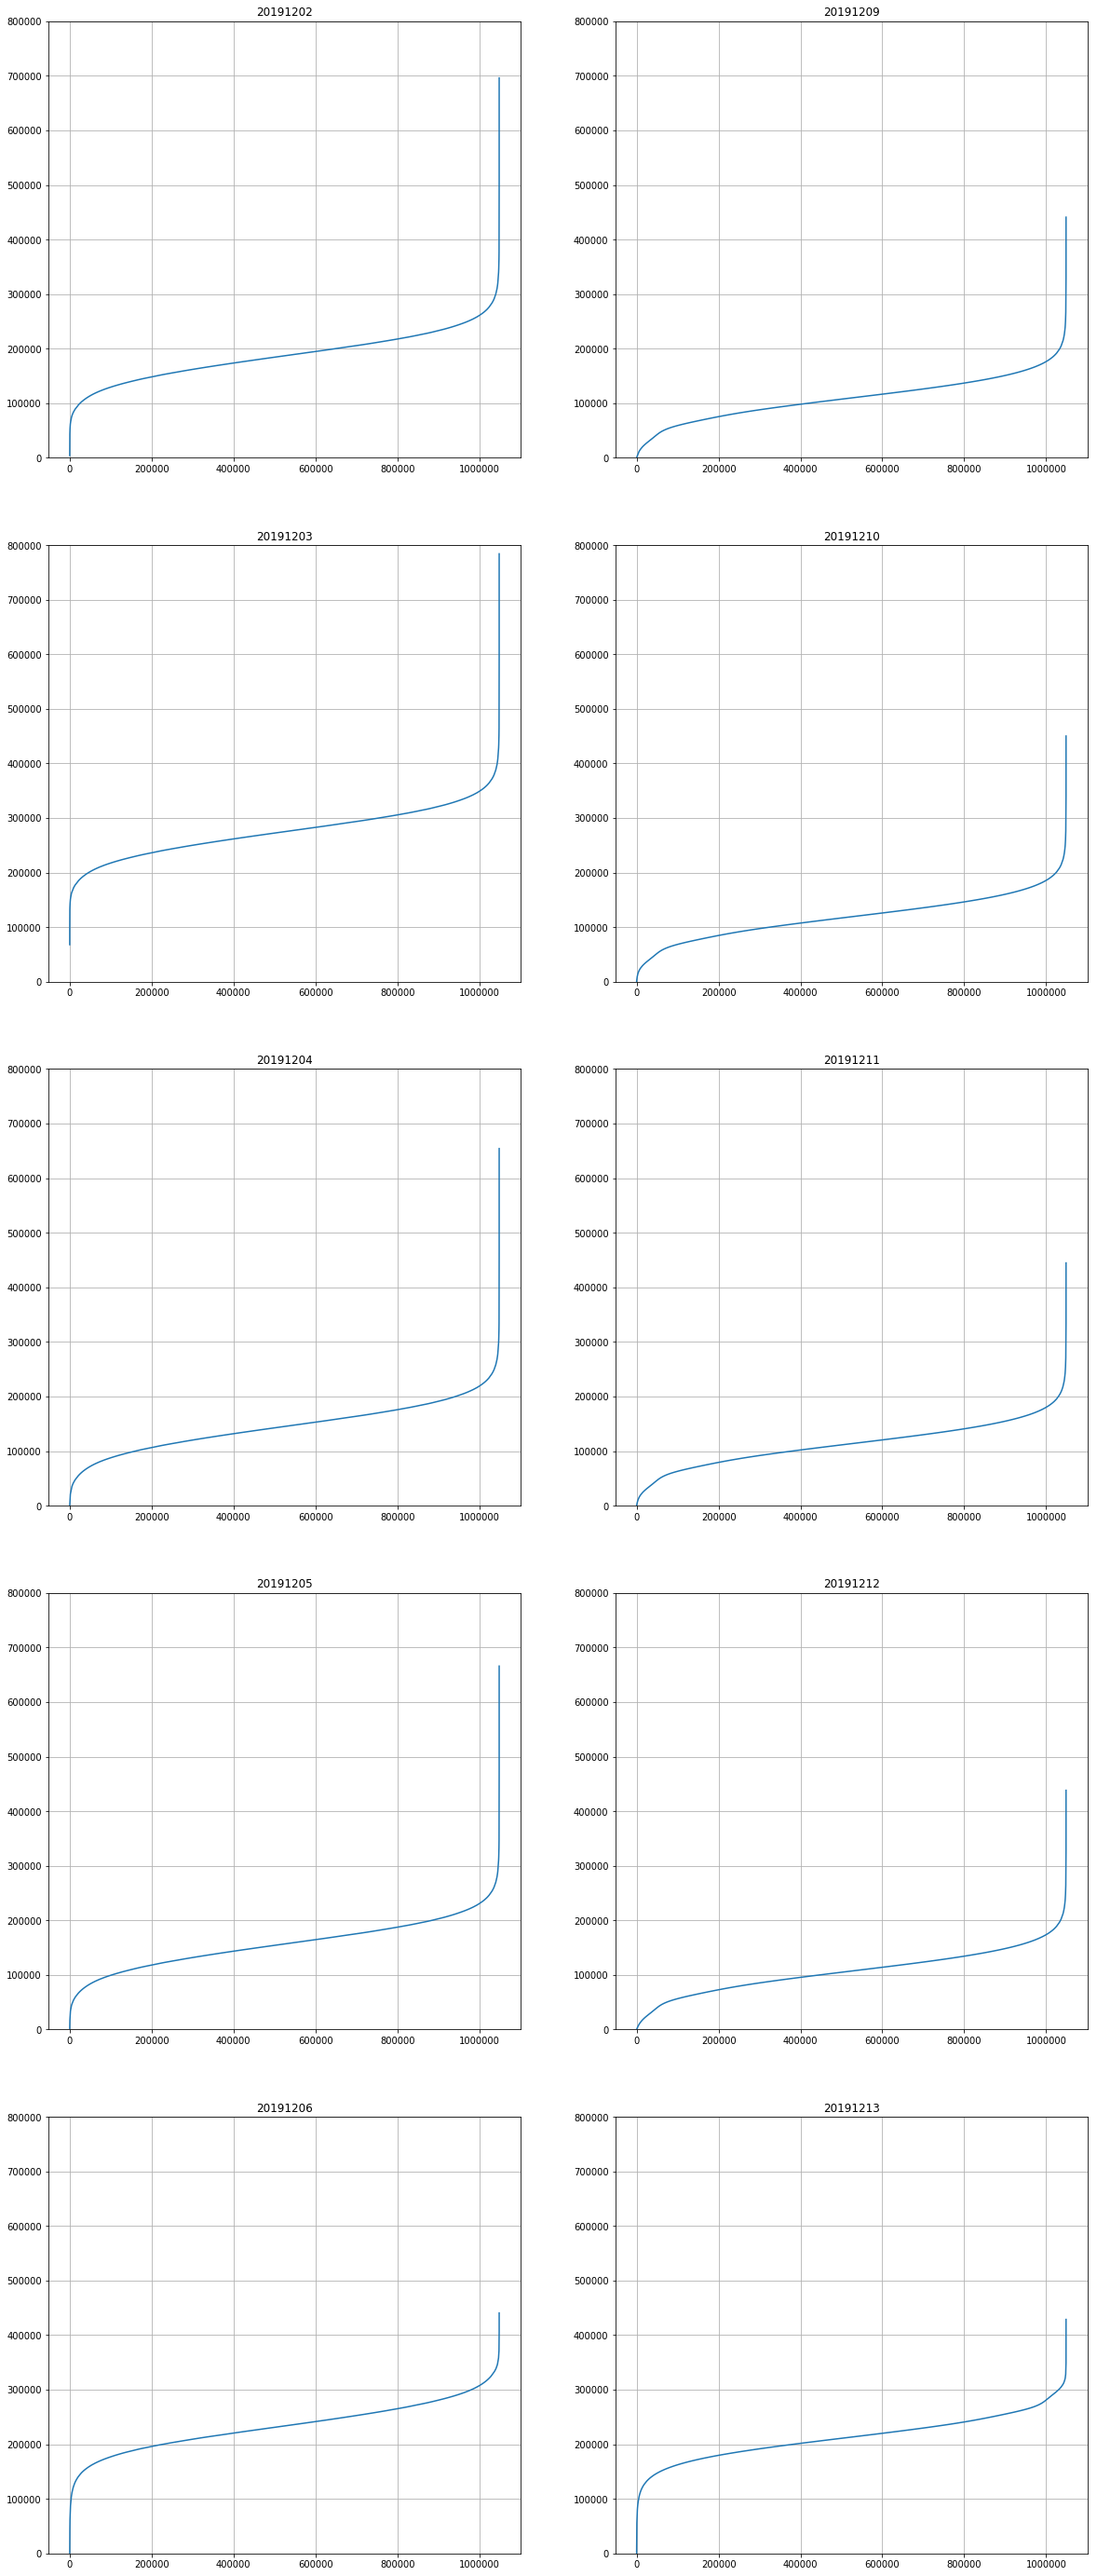

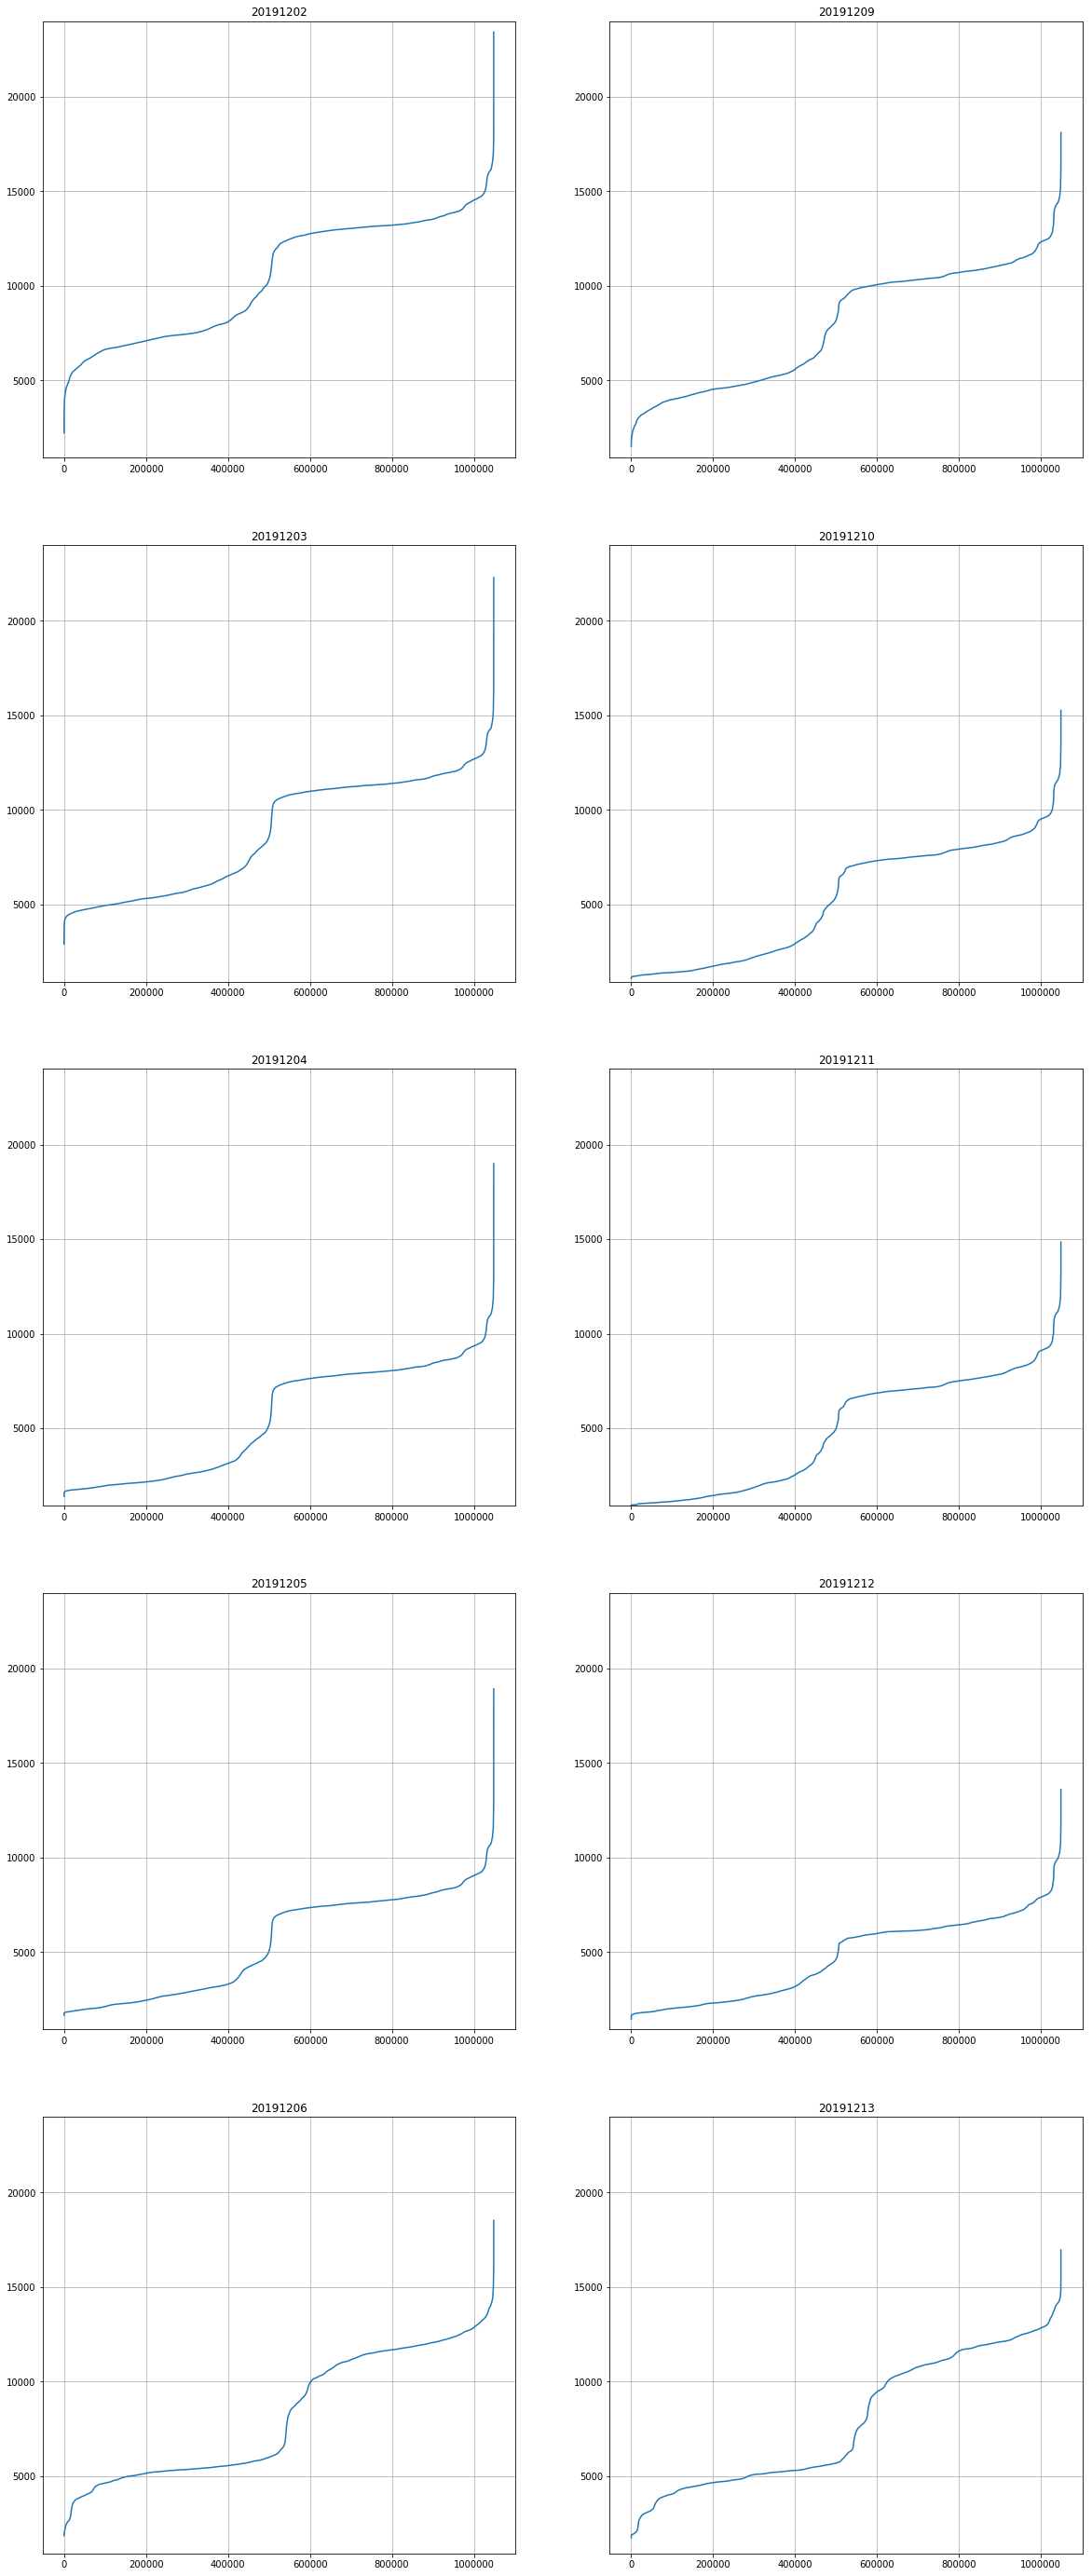

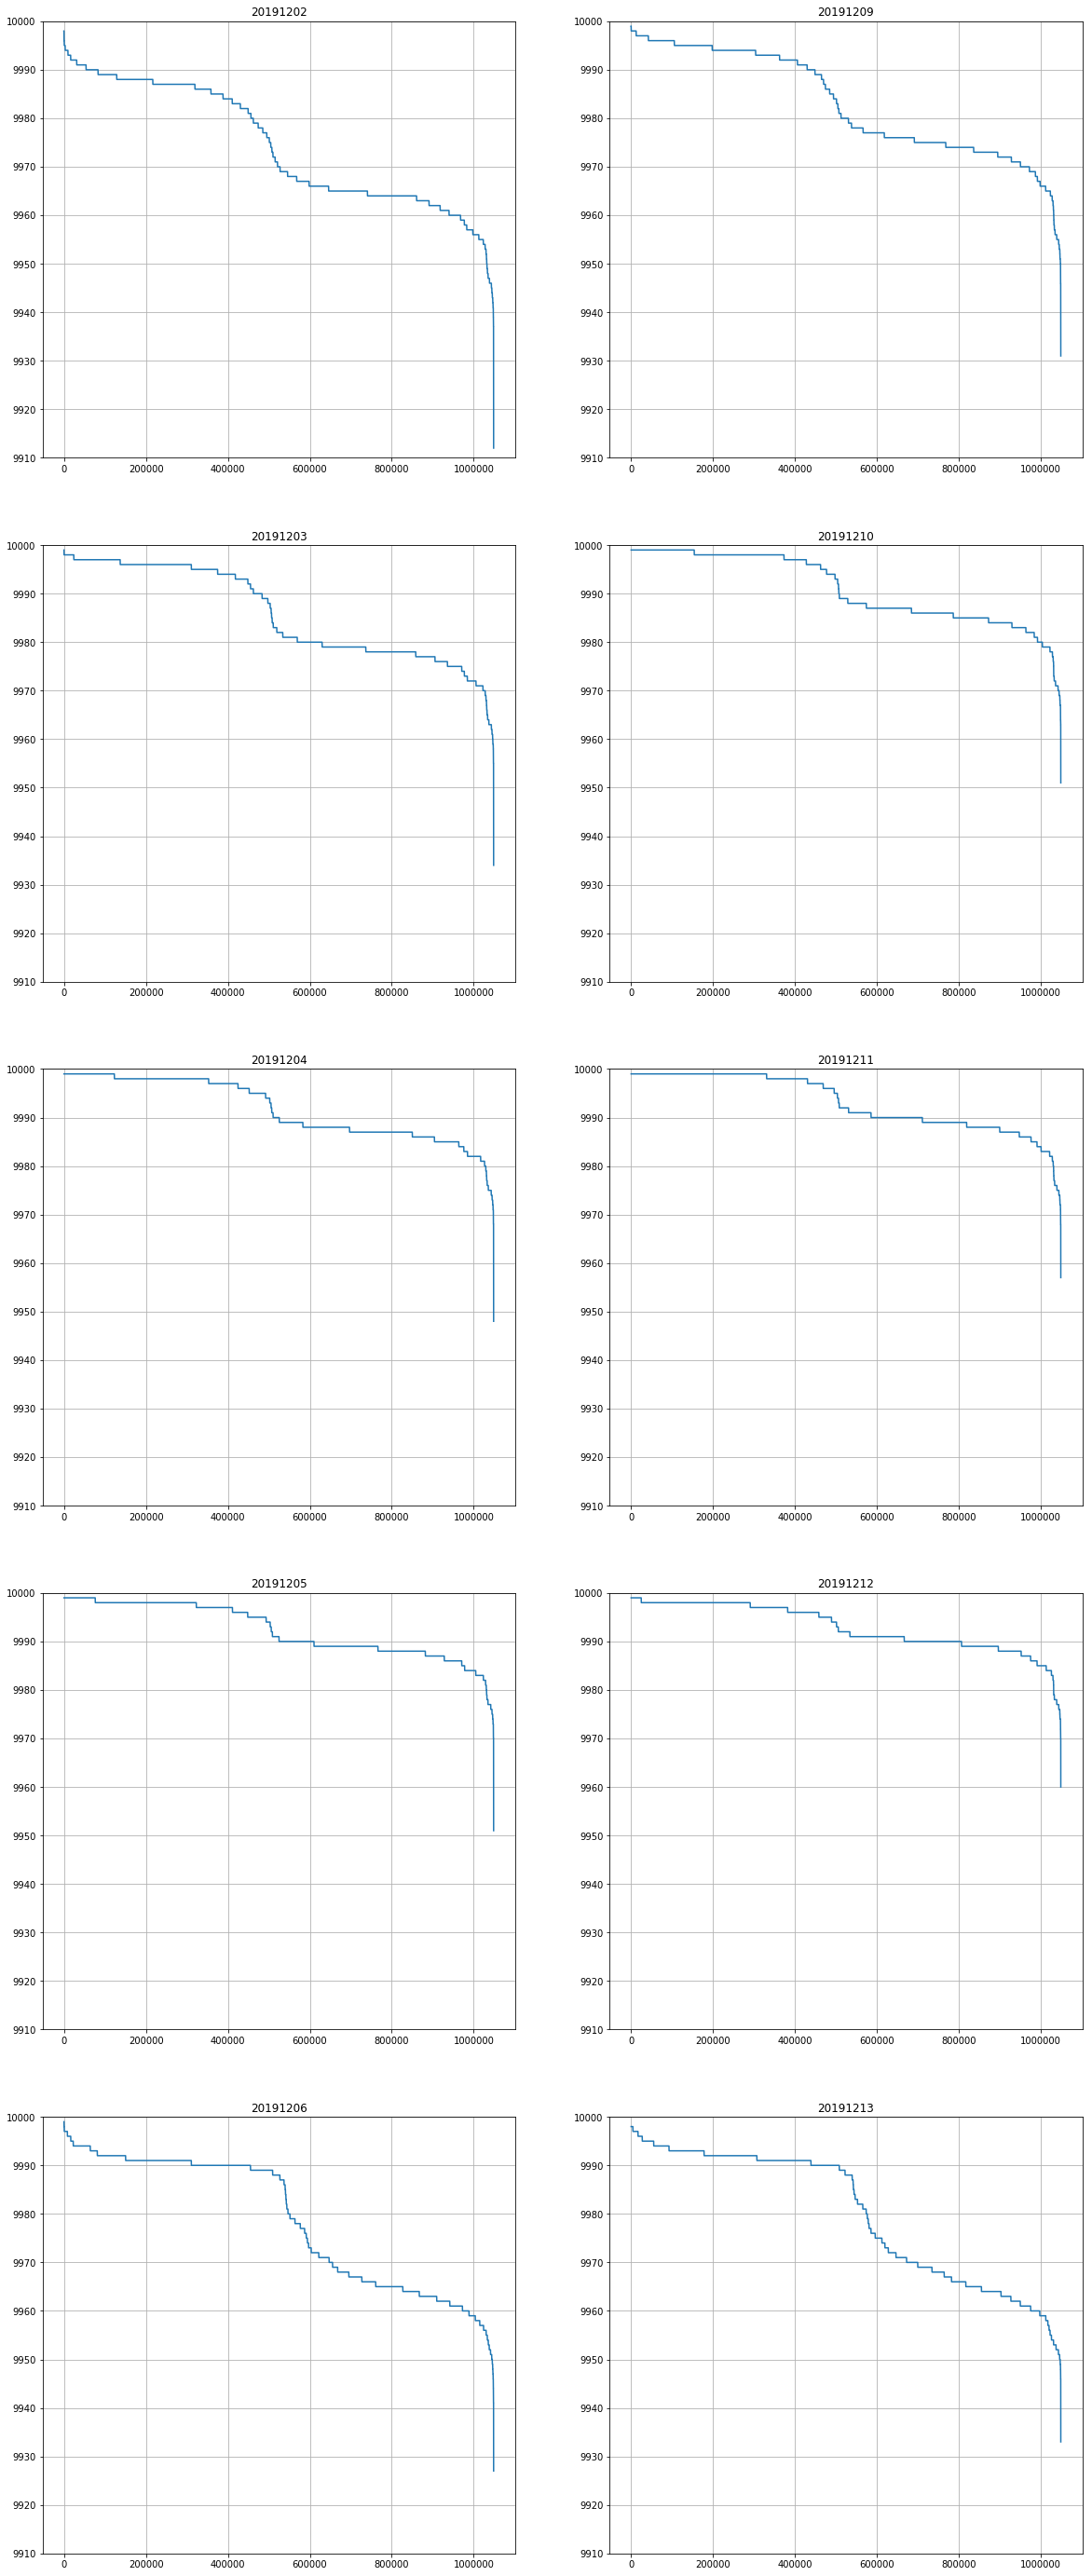

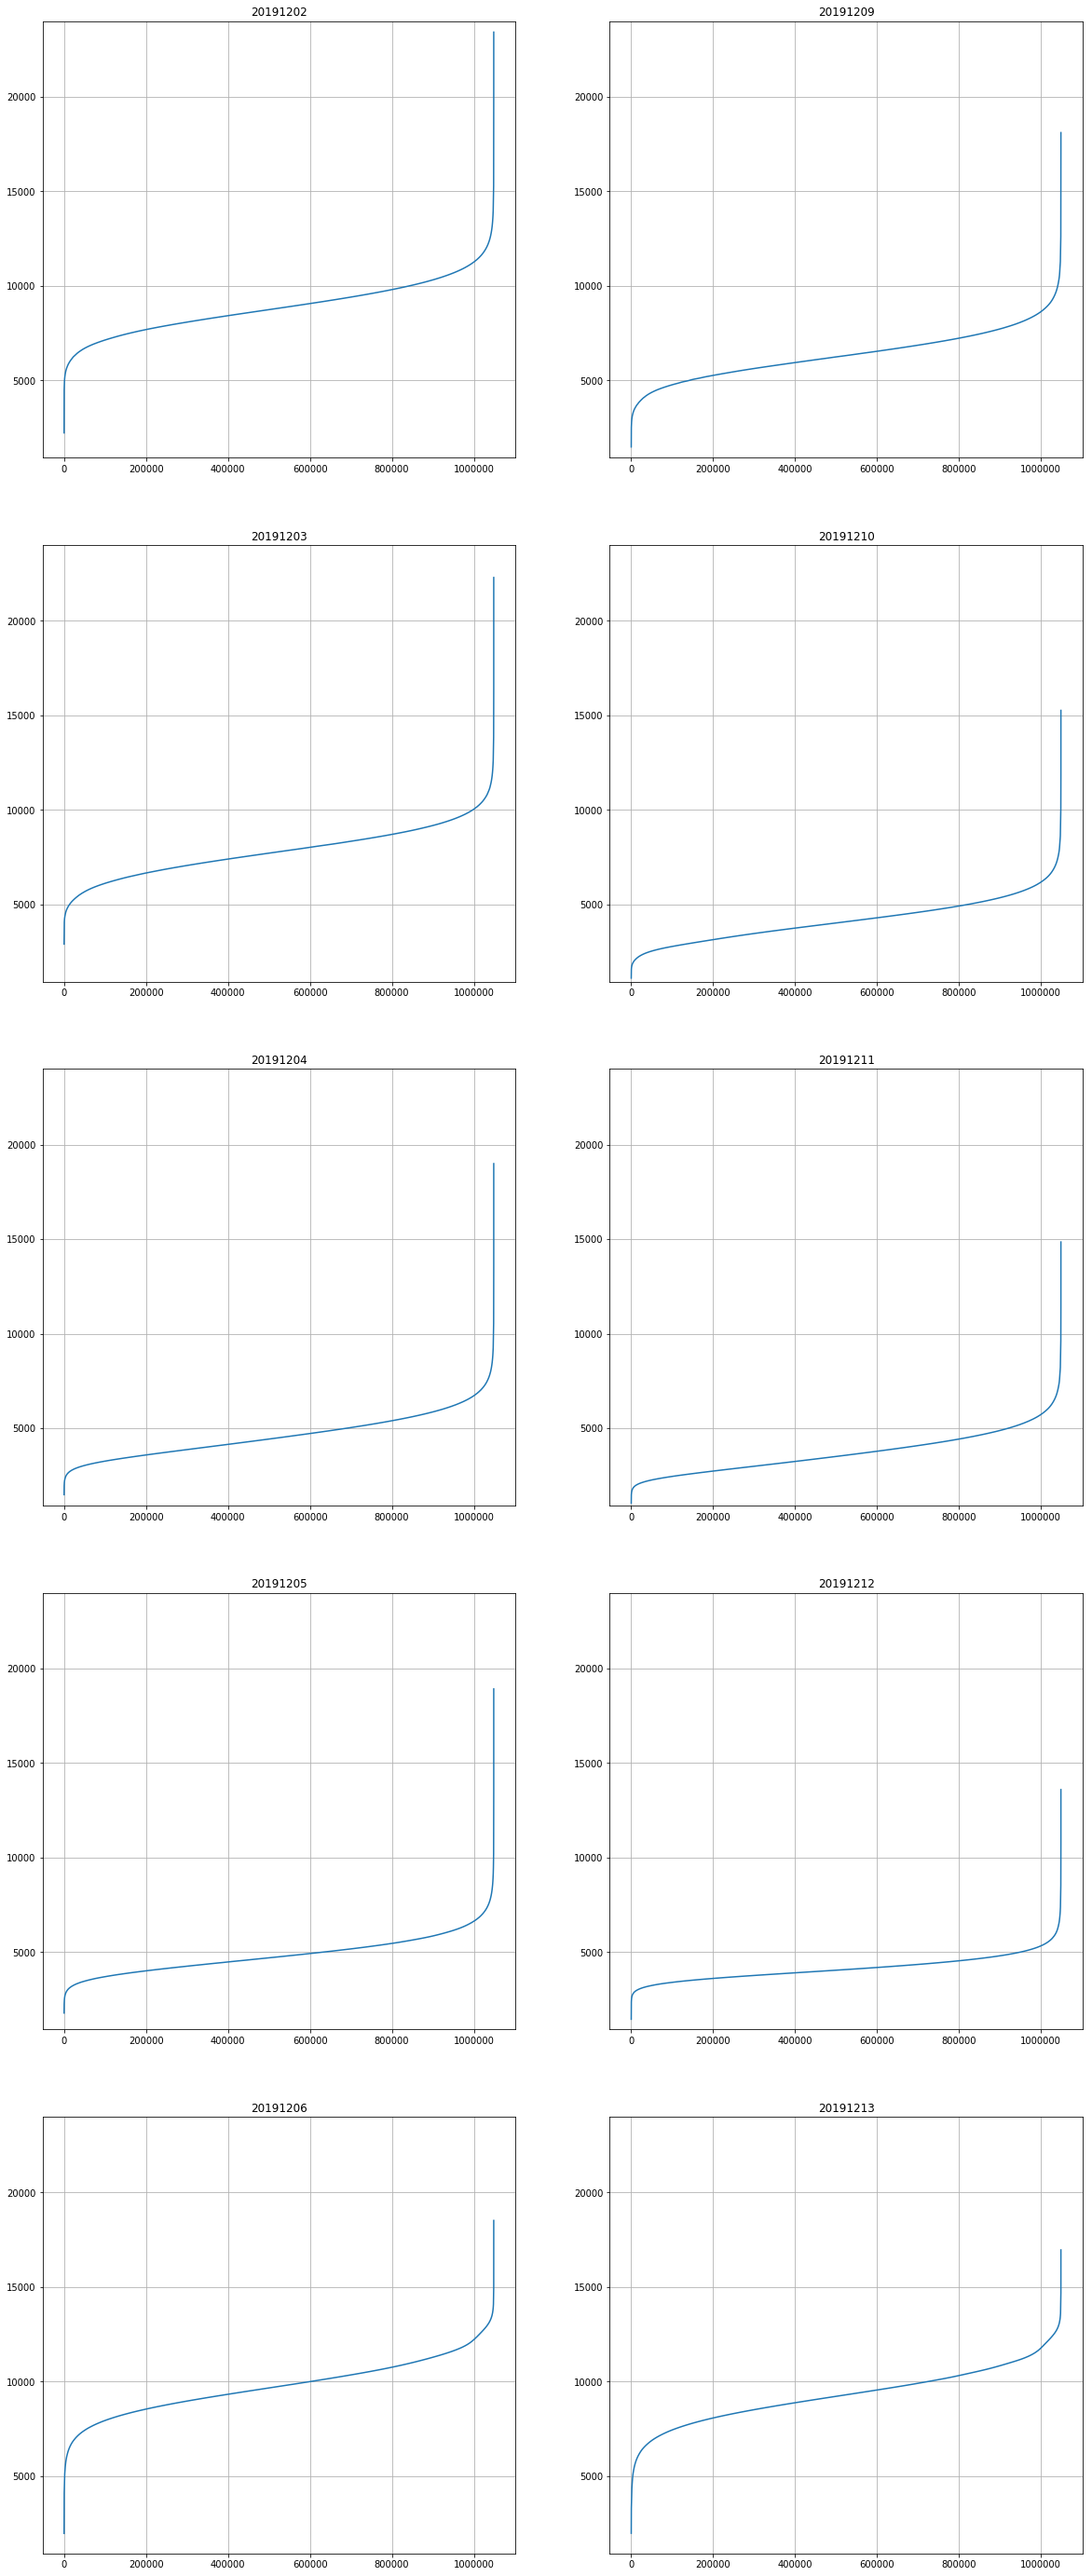

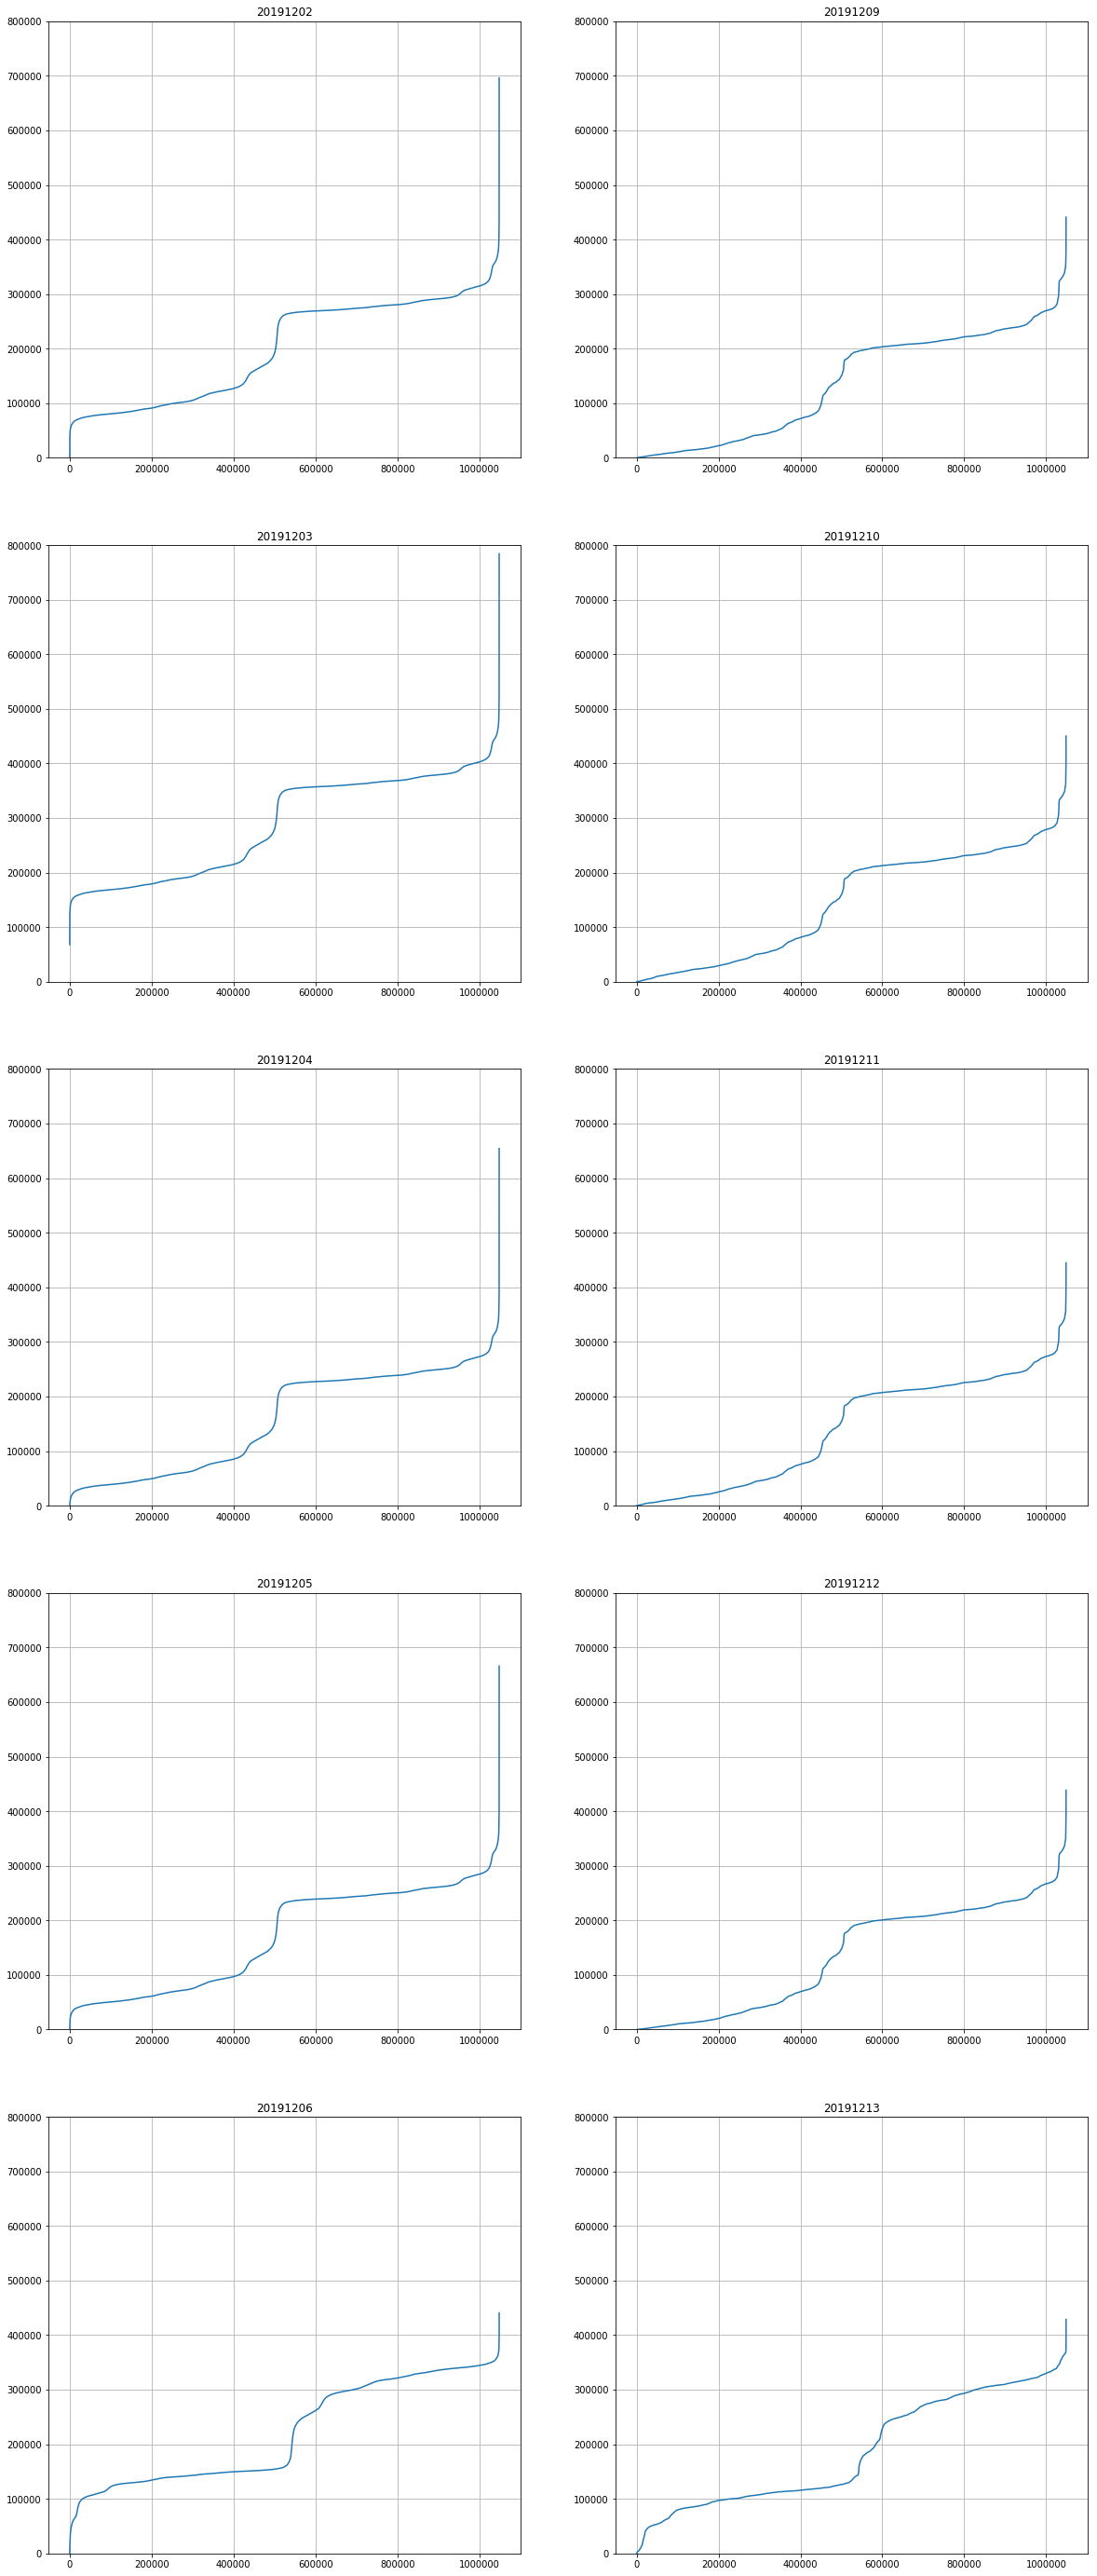

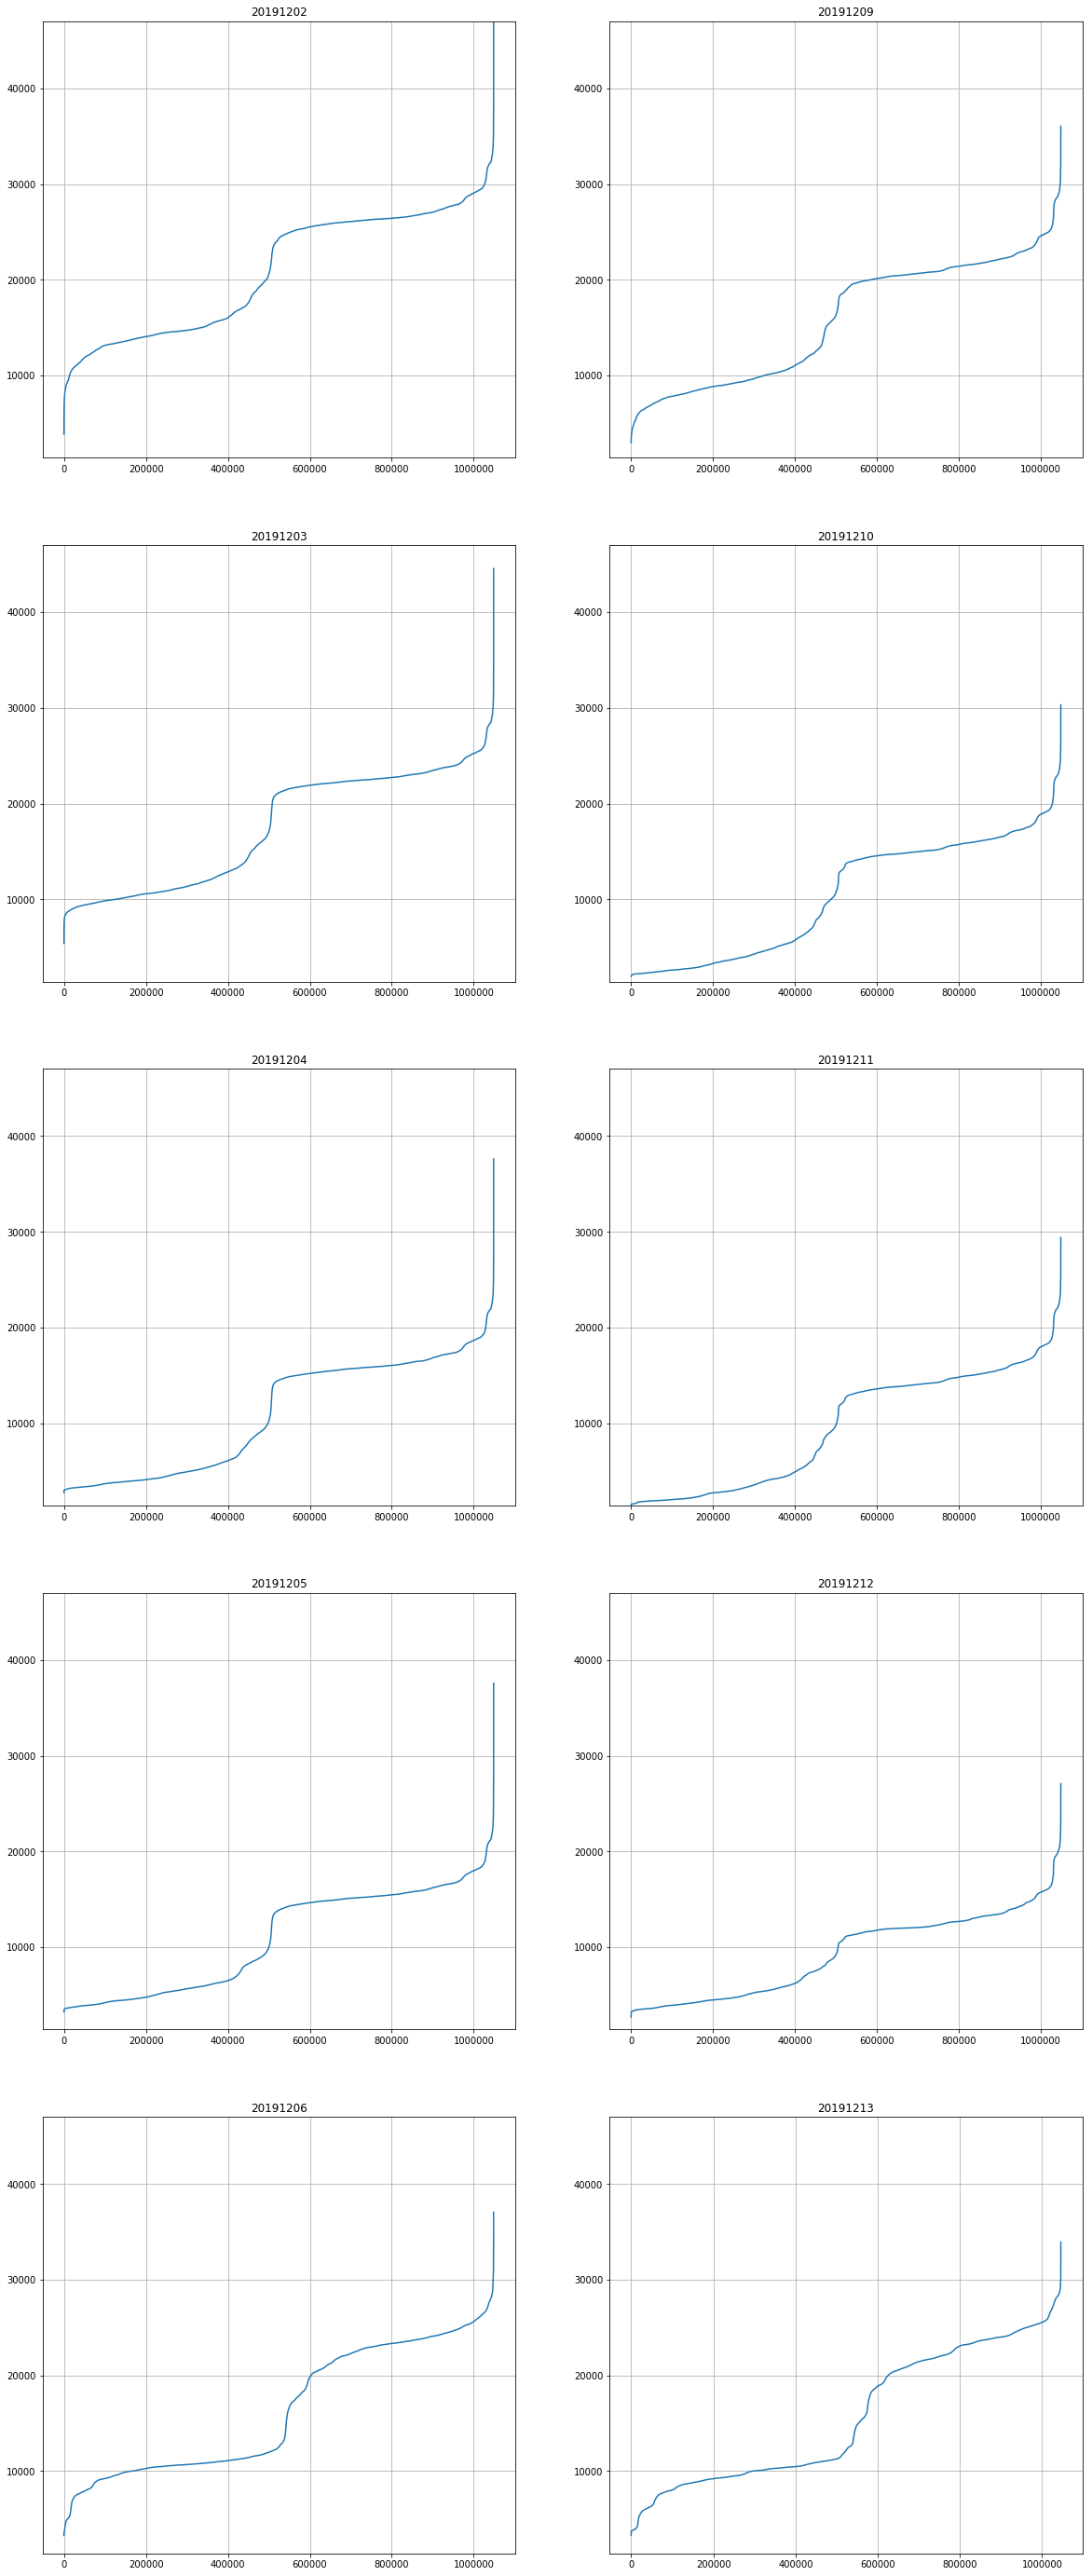

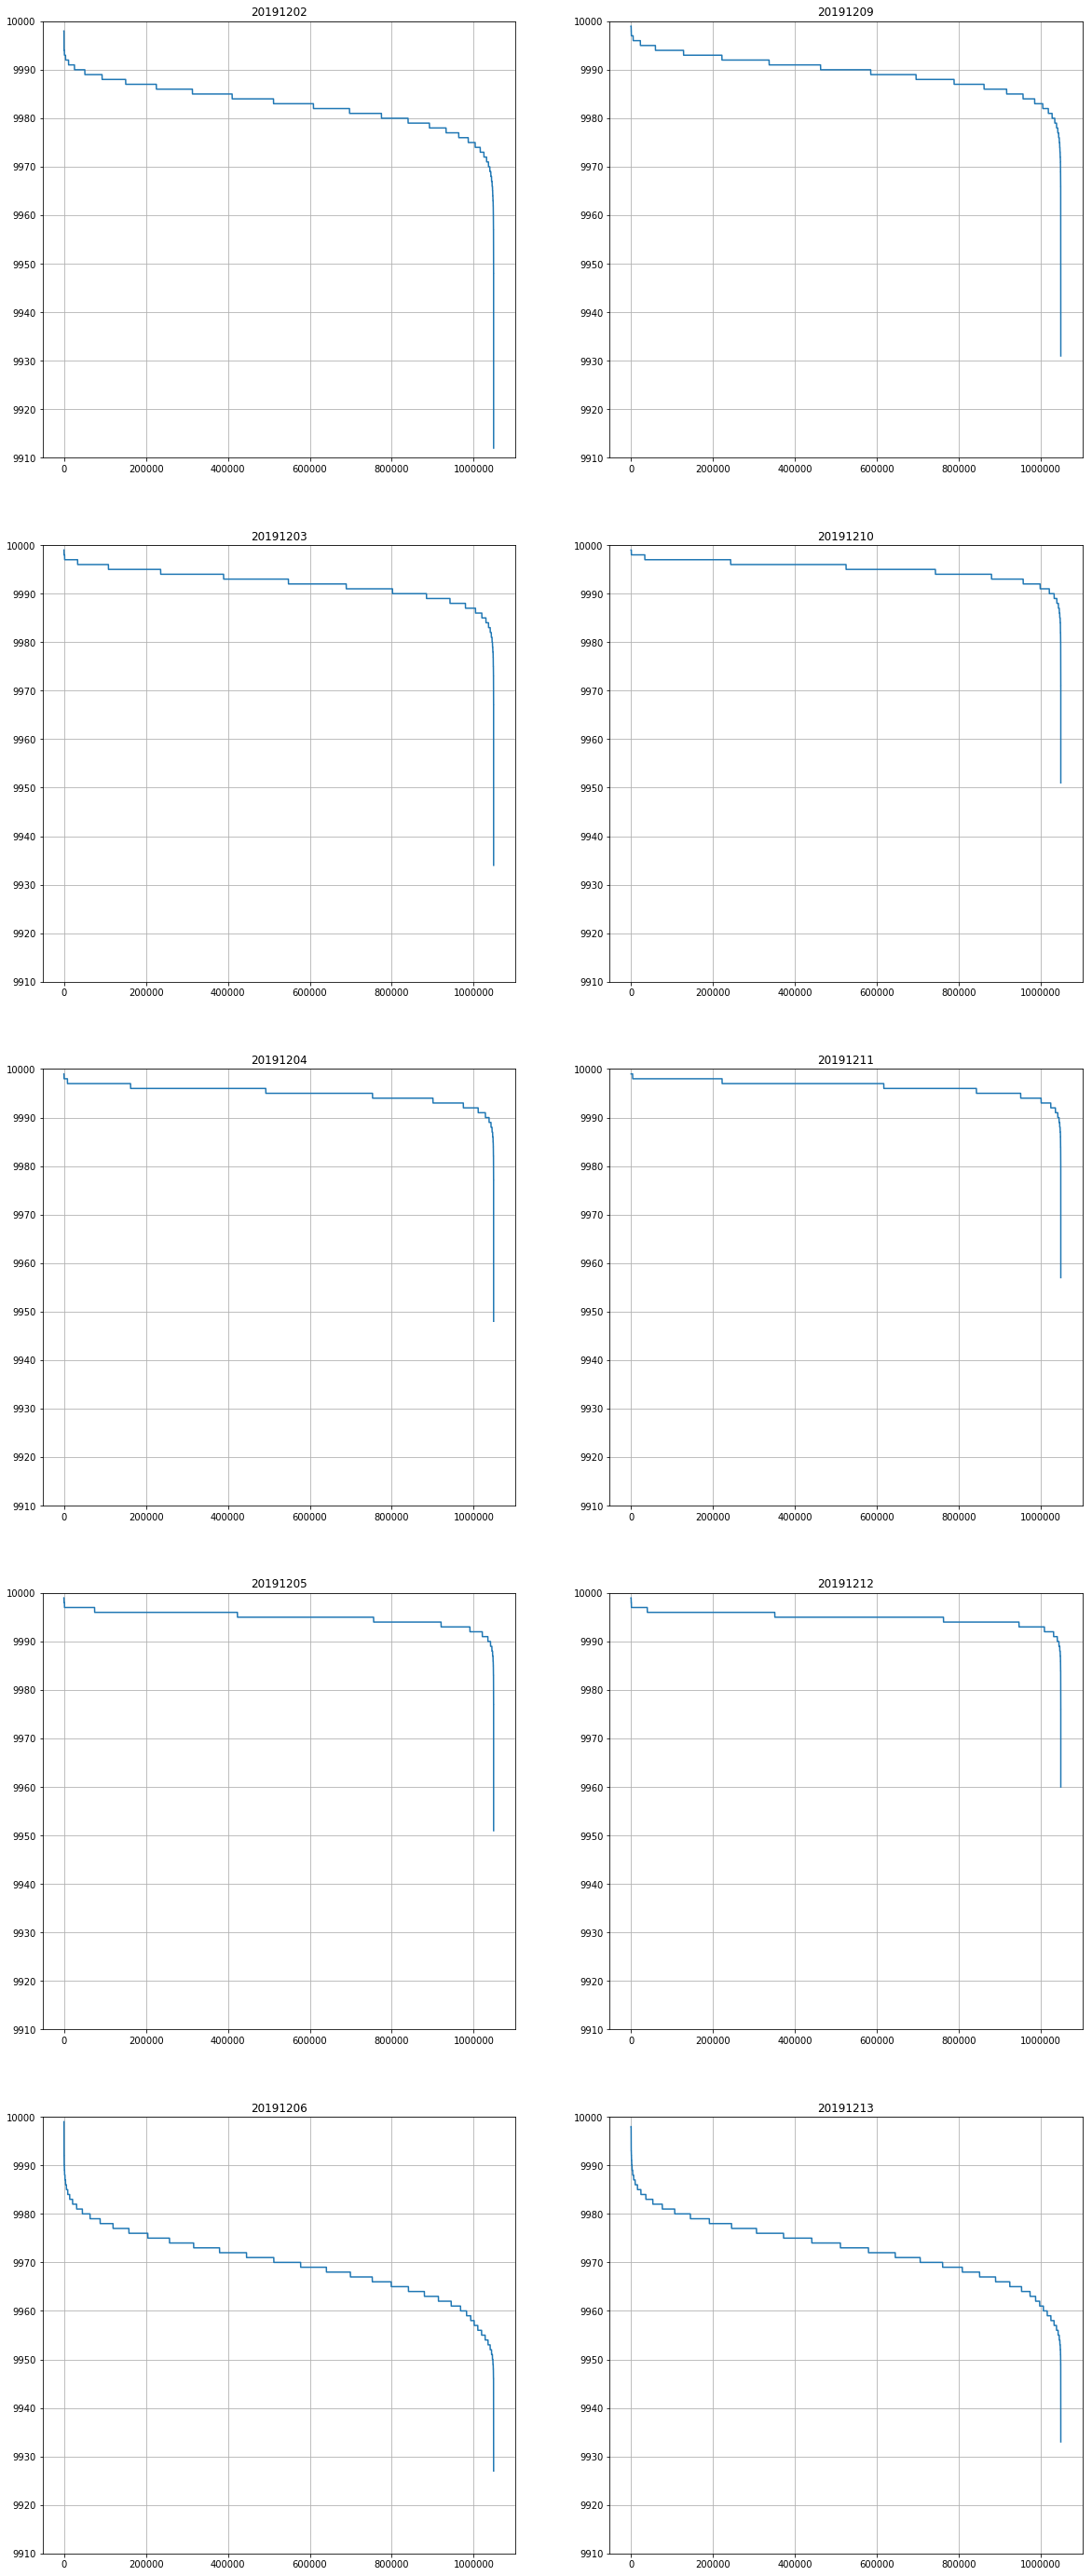

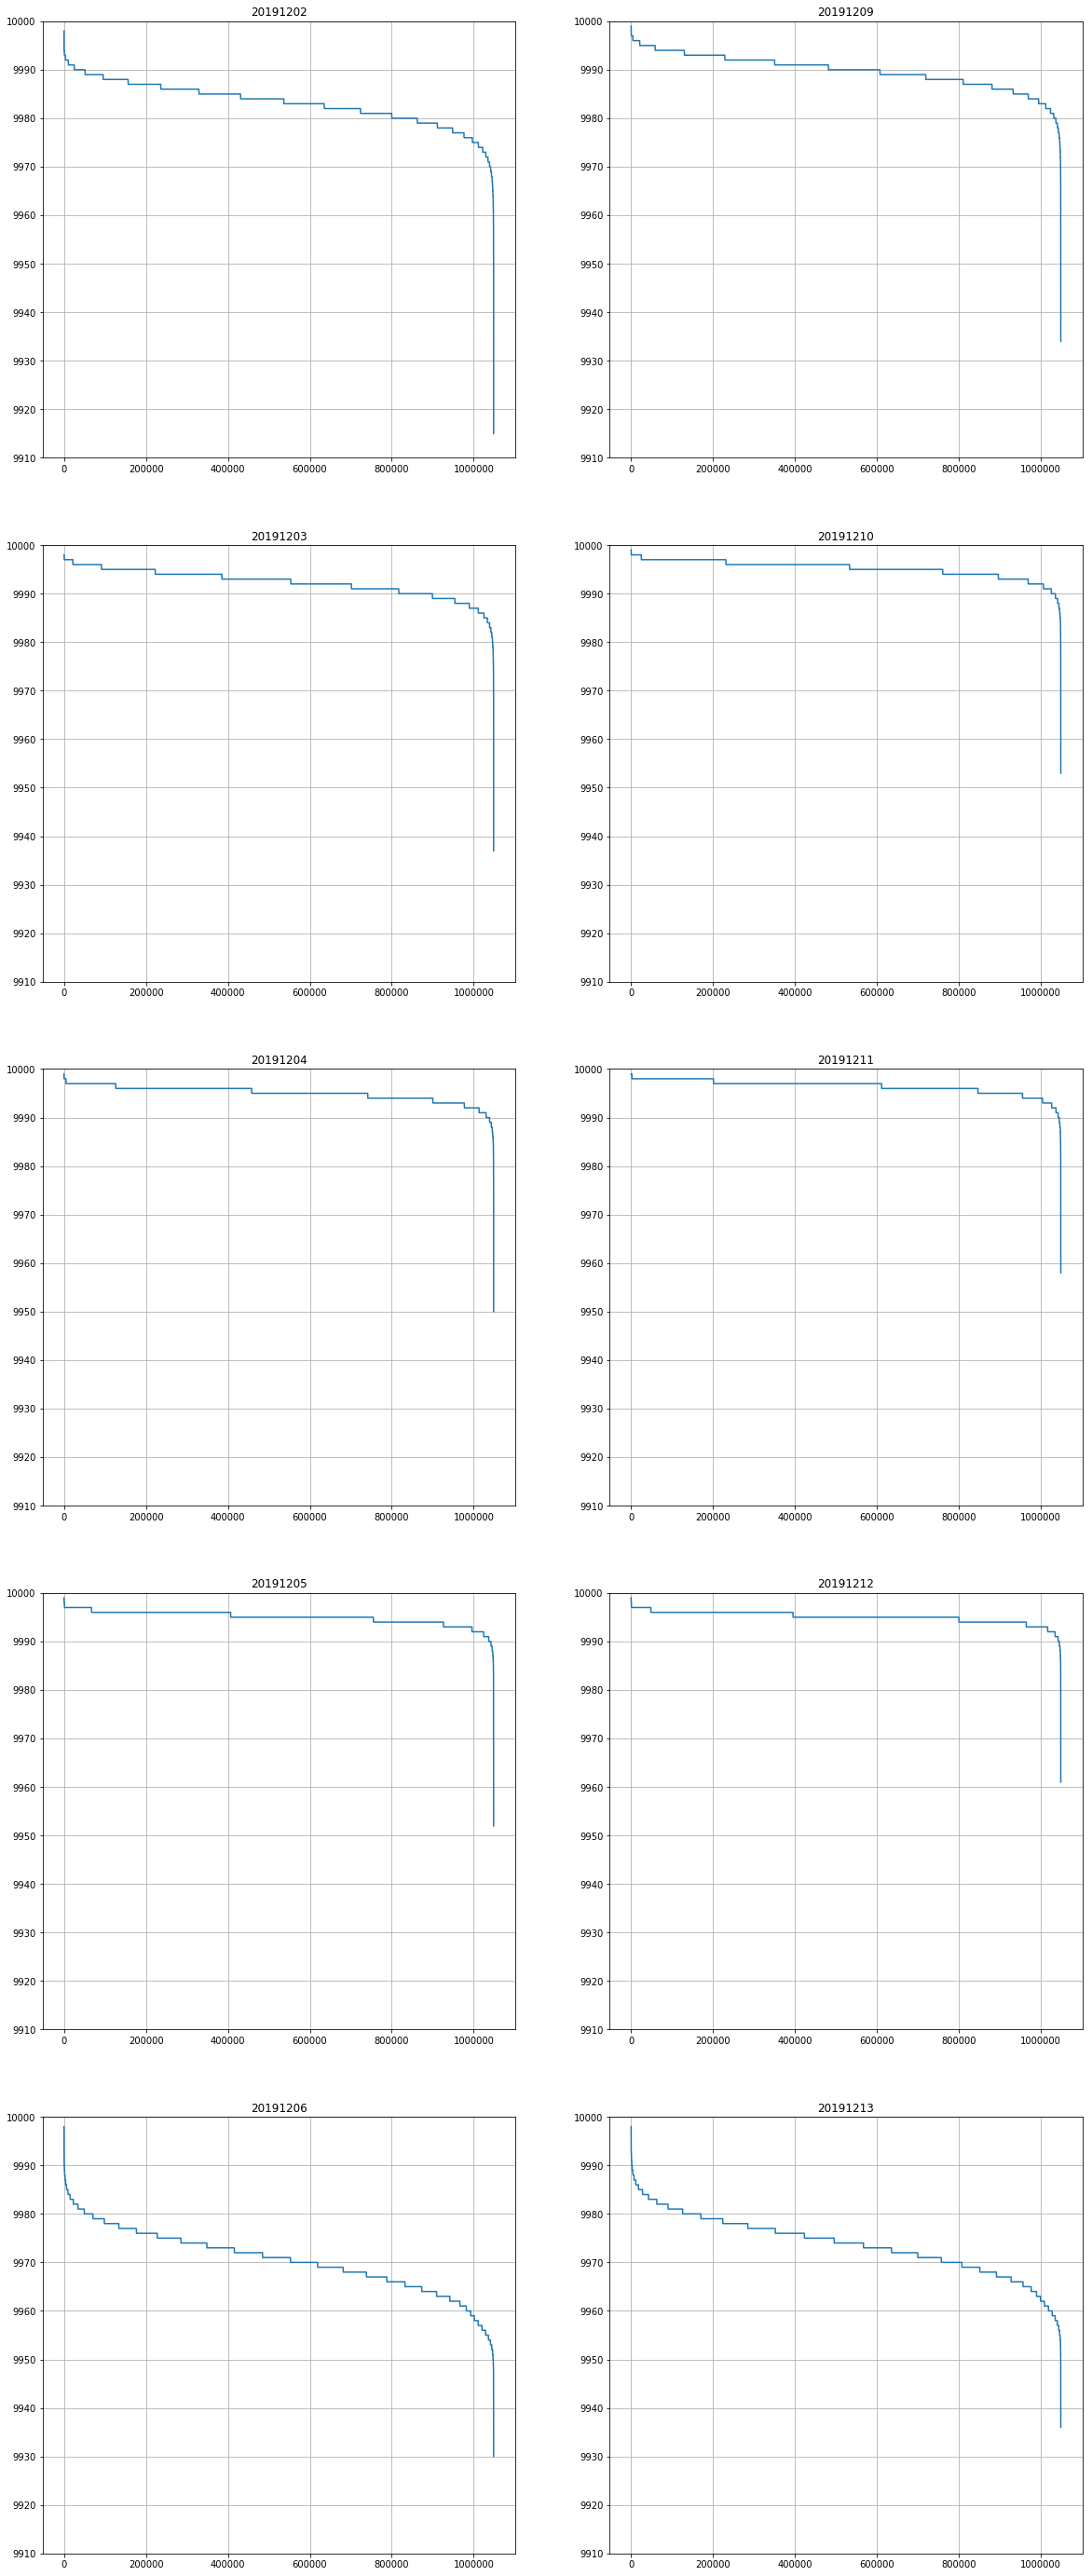

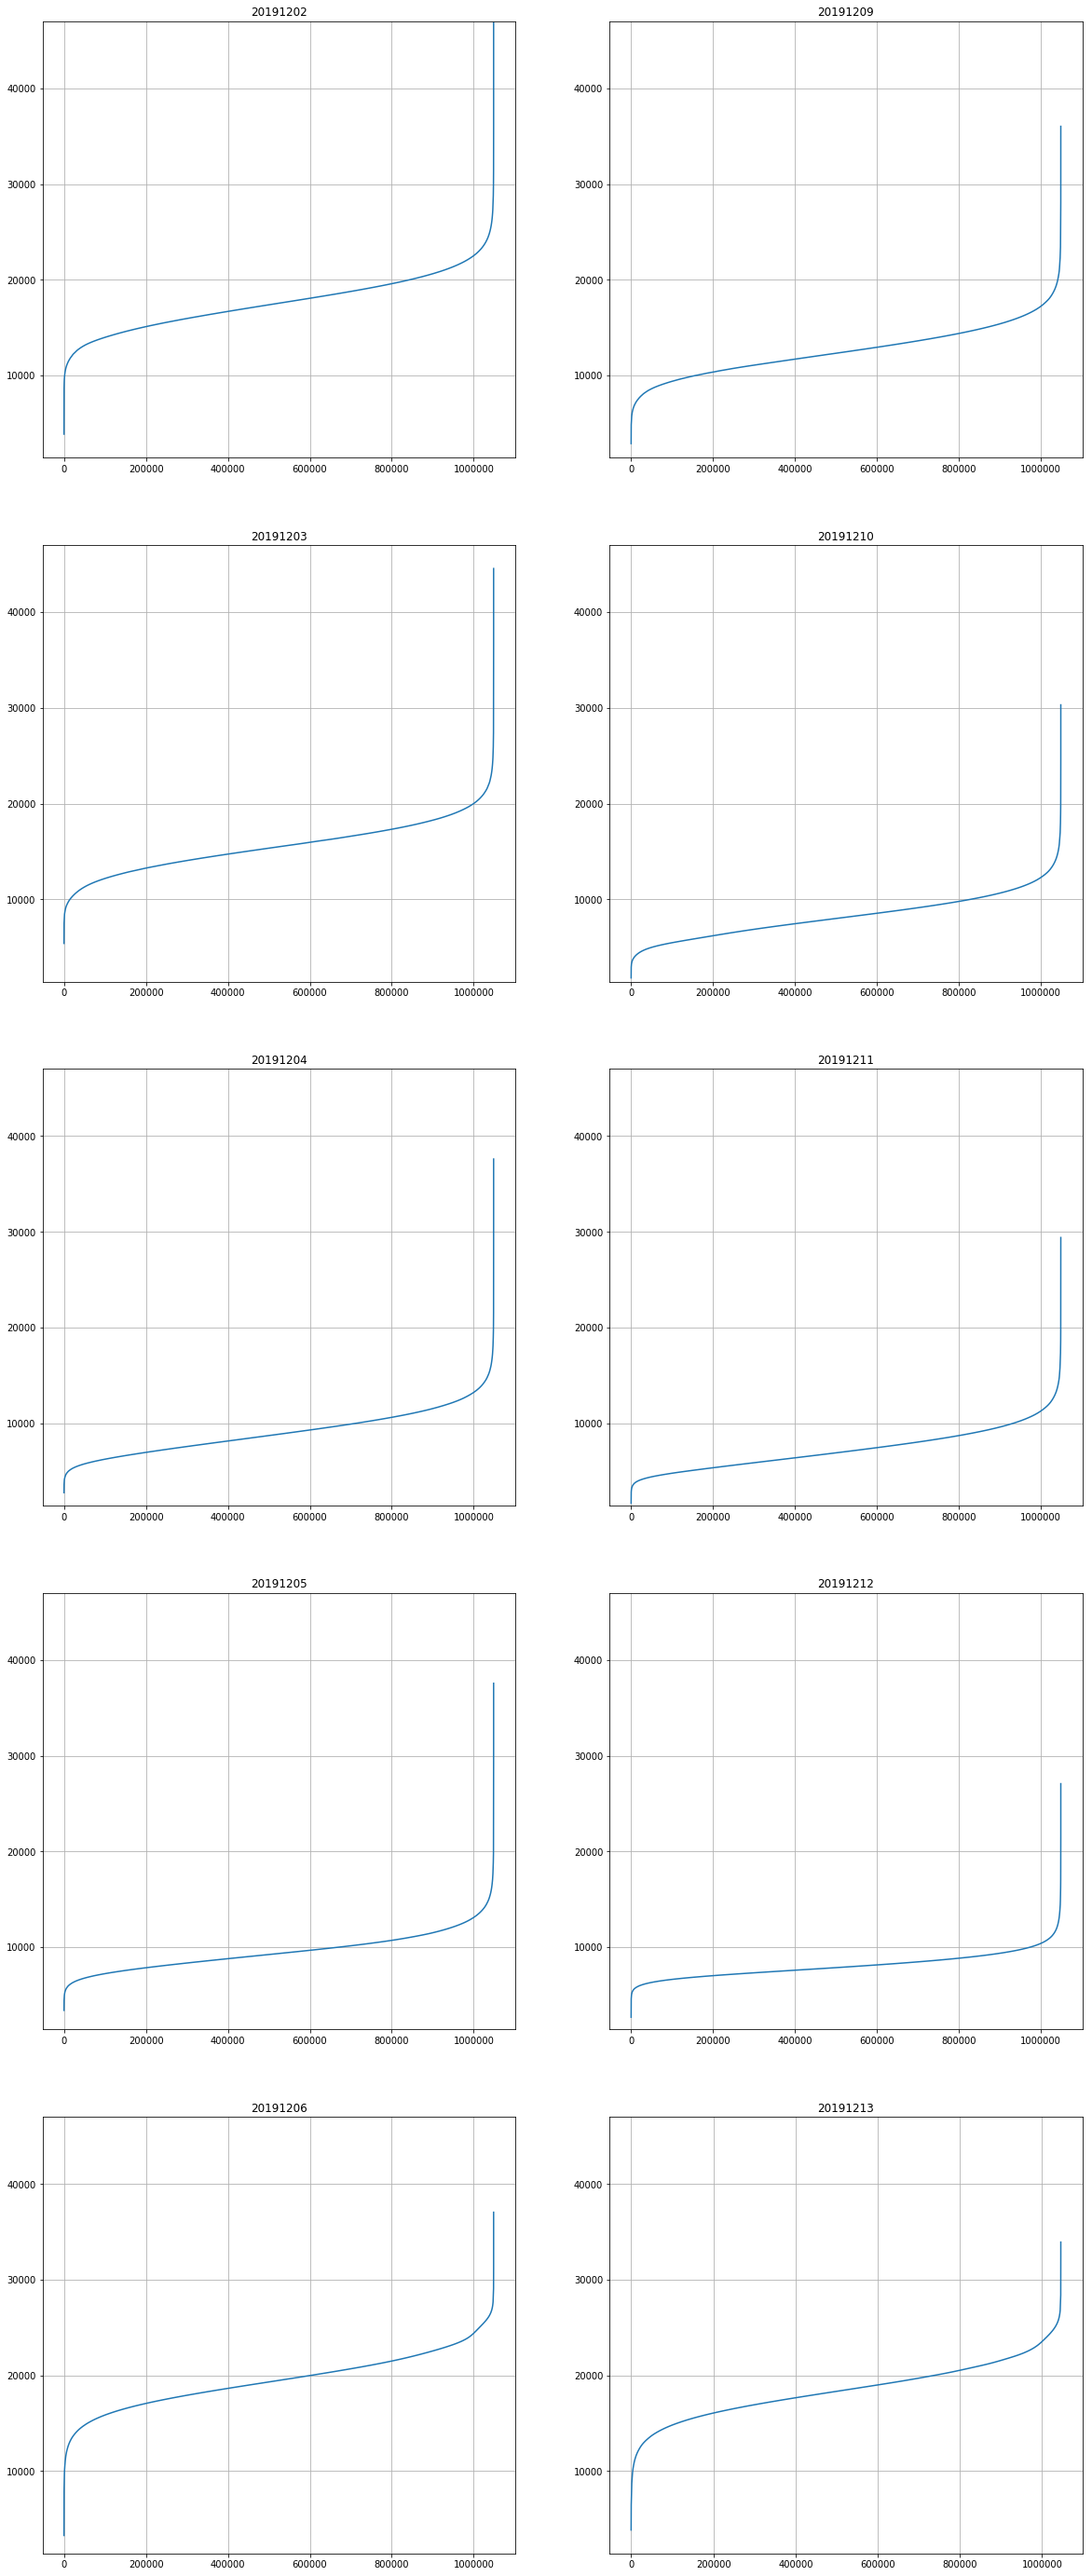

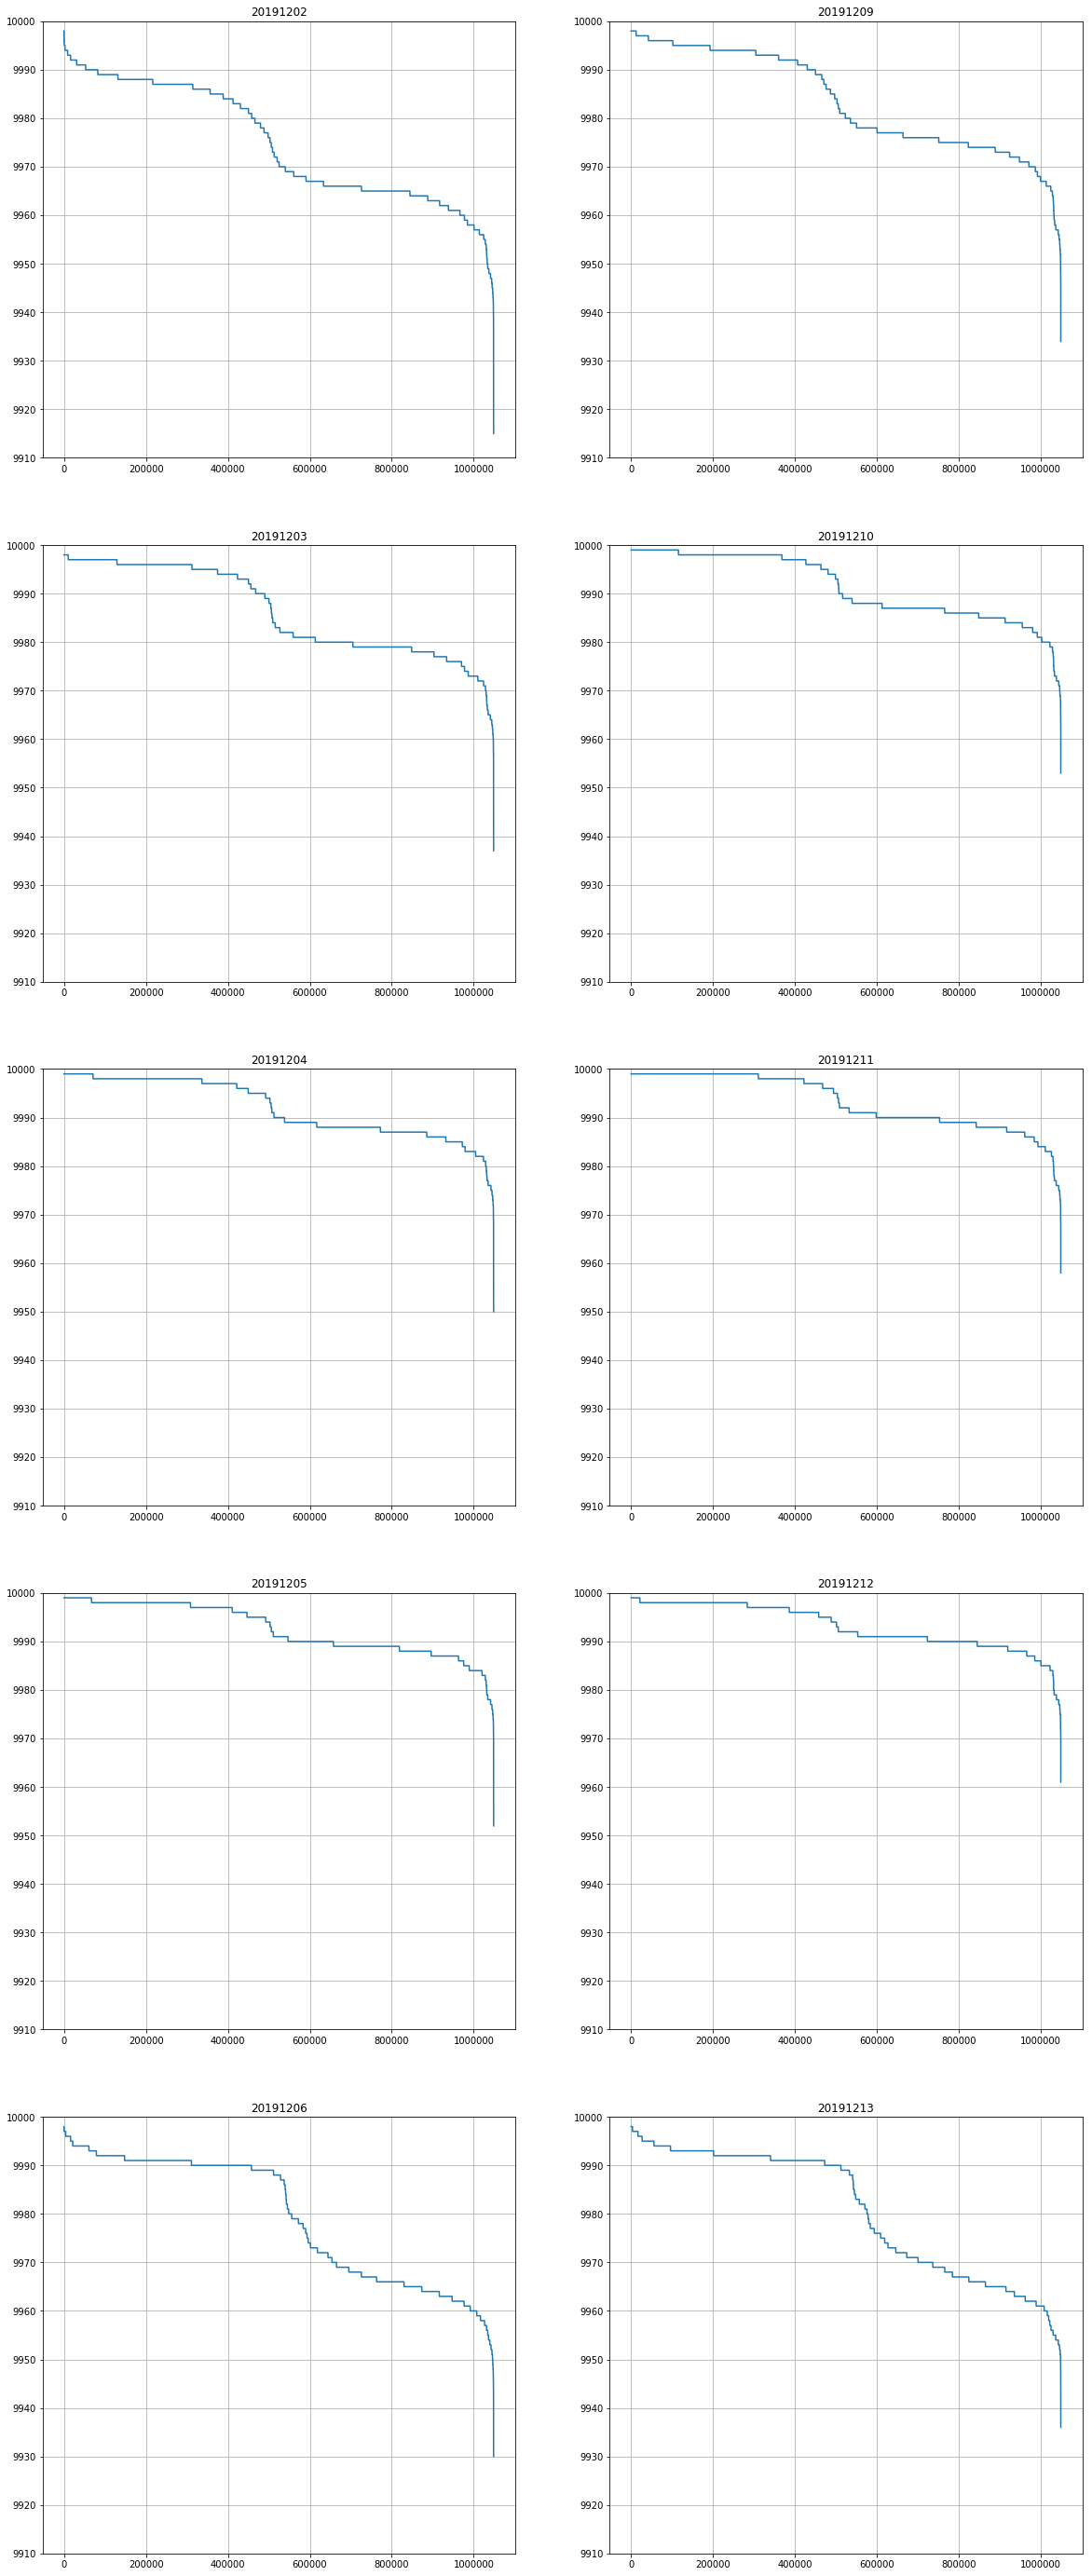

In [47]:
for dir_ in dirs:
    print(dir_)
    files = os.listdir(dir_)
    if '欧式距离' in dir_:
        ylim=[0,800000]
    elif ('平均绝对误差' in dir_) and ('30' in dir_):
        ylim=[900,24000]
    elif ('平均绝对误差' in dir_) and ('60' in dir_):
        ylim=[1400,47000]
    elif '相关系数' in dir_:
        ylim=[9910,10000]
    fig = plt.figure(figsize=(20,50))
    count=1
    for i in range(2,7):
        date1='201912'+'%02d'%i
        date2='201912'+'%02d'%(i+7)
        path1 = os.path.join(dir_,[i for i in files if date1 in i][0])
        path2 = os.path.join(dir_,[i for i in files if date2 in i][0])
        
        pd1 = pd.read_csv(path1,header=None)
        pd2 = pd.read_csv(path2,header=None)
        
        ax1 = fig.add_subplot(5,2,count) 
        ax1.plot(pd1[0],pd1[1])
        ax1.set_ylim(ylim)
        ax1.set_title(date1)
        ax1.grid()
        
        ax2 = fig.add_subplot(5,2,count+1) 
        ax2.plot(pd2[0],pd2[1])
        ax2.set_ylim(ylim)
        ax2.set_title(date2)
        ax2.grid()
        
        count=count+2
        
    plt.savefig(dir_)